# Inner Core Lightning Threshold Analysis
In this notebook, we define the threshold for what constitutes a "lightning burst" in the inner core of a tropical cyclone. 

### How do we define a burst of lightning?
We define a lightning burst based off the number of lightning instances in a 30-minute time bin.
We start by assuming the distribution of lightning in the inner core is Gaussian.

### Code
Let's start by importing necessary libraries and files. The inner core dataset is created in the `data_cleaning_combined_data.ipynb` notebook (!!!!!!!!!need to rename this notebook lol)

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

In [2]:
# import data from csv file
innercore_data = pl.read_csv("WWLLN_innercore_timebin_count.csv")
innercore_data = innercore_data.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin")
)
innercore_data = innercore_data.rename({"lightining_count":"lightning_count"}) # fix typo, can remove after it's fixed in file
innercore_data.head()

storm_code,time_bin,lightning_count
str,datetime[μs],i64
"""ATL_10_1""",2010-06-21 07:00:00,1
"""ATL_10_1""",2010-06-23 14:30:00,1
"""ATL_10_1""",2010-06-23 15:00:00,3
"""ATL_10_1""",2010-06-23 16:30:00,2
"""ATL_10_1""",2010-06-23 22:30:00,4


Let's start by plotting a histogram of lightning counts for one TC first.

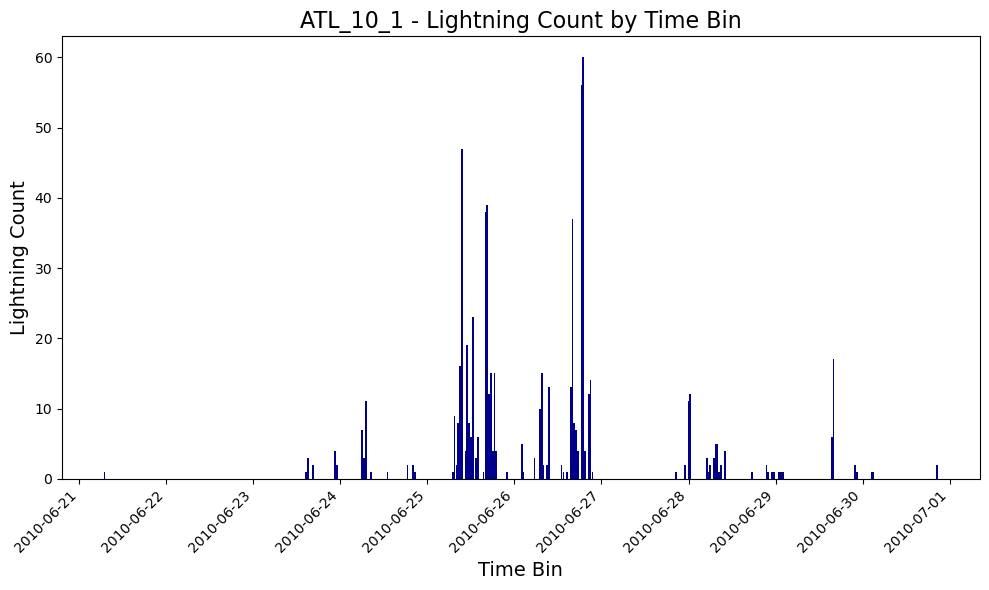

In [13]:
# Convert Polars DataFrame to pandas for plotting
innercore_data_subset = innercore_data.filter(pl.col("storm_code") == "ATL_10_1")
atl_10_1 = innercore_data_subset.to_pandas()

# Plot histogram (bar chart)
plt.figure(figsize=(10, 6))
plt.bar(atl_10_1["time_bin"], atl_10_1["lightning_count"], color="darkblue", width=0.02)

# Format plot
plt.title("ATL_10_1 - Lightning Count by Time Bin", fontsize=16)
plt.xlabel("Time Bin", fontsize=14)
plt.ylabel("Lightning Count", fontsize=14)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()